# Different data structures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%matplotlib widget

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import jupyter_black

jupyter_black.load()

# Project
from src.data_connectors import read_input_files
from src.data_preparation import search_space
from src.data_connectors.read_input_files import Instance

In [3]:
instance = 333
instances_path = "../data/input/HRTInstances"
ins_x = read_input_files.read_file(
    os.path.join(instances_path, f"Instance_{instance}.txt")
)

In [4]:
ins_x.df_setup

,Humans,Robots,WorkingSpaces
0,2,3,3


In [5]:
ins_x.df_resources

,Type,Id
0,H,0
1,H,1
2,R,2
3,R,3
4,R,4


In [6]:
ins_x.df_workingspace_resources

,WorkingSpace,Resource
0,1,2
1,1,0
2,1,1
3,2,3
4,2,0
5,2,1
6,3,4
7,3,0
8,3,1


In [7]:
ins_x.df_workingspace_id.head()

,WorkingSpace,Id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


## [Flow](https://miro.com/app/board/uXjVPyl00iw=/)

1. Generate **Initial Population**
2. Verify if order of genes is violating the precedence
    1. Discard those that are violating the precedence
3. Duplicate it for all the jobs in the same instance (SAC)
4. Create the array of times (start and end), using the resources time estimator for the respective mode allocation
5. **Fitness Function**: Compute the total time to complete all the jobs in all working spaces of same instance $\Longrightarrow C$ 
6. **Selection**: Retain the genes with lower C (at maximum X)
    1. Discard those that have larger C
    2. Verify if new population has a significant improvement in total C from previous population.
7. **Generate next population**:
    1. **Crossover**: from survival chromosomes, create offsprings 
    2. **Mutation**: add mutation to the created offsprings (initially larger %, and decreases over time).
8. Return to point **2**.

### 0. The chromosome

```python
chromosome = {
    'mode': [0, 1, 2, 2, 1, ... ], # resource ID
    'order': [2, 3, 1, 4, 5, ...], # order of tasks of each position
    }

```

In [8]:
from src.genetic_algorithm.chromosome import Chromosome

### 1. Generate initial population

By default, it generates population for 1 working space:

**Note**:
- *It is important to generate a large first population, because a lot chromosomes might not survived due to feasibility of solutions.*

In [9]:
from src.genetic_algorithm import first_population

# Modes

possible_modes = first_population.get_possible_modes(ins_x)
# Tasks
n_tasks = first_population.get_total_number_of_tasks_per_working_space(ins_x)

# Chromosomes
chromosomes = first_population.get_first_population(possible_modes, n_tasks)

Possible modes: ['0' '1' '2' '0-2' '1-2']
Number of tasks: 20
Total size of first population: 6600


### 2. Verify feasibility of solutions

We need to verify:
- the precedence is valid
- the combination of modes and tasks is possible (the selected mode can perform the associated task) 

In [10]:
from src.genetic_algorithm import feasibility

In [11]:
ins_x.df_predecessor_sucessor.head()

,Predecessor,Sucessor
0,1,2
1,2,3
2,3,4
3,1,4
4,1,5


In [12]:
precedence_feasible_chromosomes = []
for i in range(len(chromosomes)):
    chrom = chromosomes[i]
    if feasibility.is_chromosome_precedence_feasible(ins_x, chrom):
        precedence_feasible_chromosomes.append(chrom)

print(f"From {len(chromosomes)} to {len(precedence_feasible_chromosomes)}")

From 6600 to 110


In [13]:
task_mode_feasible_chromosomes = []
for i in range(len(precedence_feasible_chromosomes)):
    chrom = precedence_feasible_chromosomes[i]
    if feasibility.is_chromosome_task_mode_feasible(ins_x, chrom):
        task_mode_feasible_chromosomes.append(chrom)

print(
    f"From {len(precedence_feasible_chromosomes)} to {len(task_mode_feasible_chromosomes)}"
)

From 110 to 110


### 3. Increment duplication with possible extra working spaces

1. e.g. if other working spaces exist, duplicate the working modes, and duplicate the orders

In [103]:
from src.genetic_algorithm import replication

In [104]:
# Generate new orders
chromosome = task_mode_feasible_chromosomes[0]
chromosome

Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [105]:
chromosome_with_replication = replication.update_chromosome_with_replication(
    ins_x, chromosome
)

In [106]:
chromosome_with_replication

Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59])

In [109]:
# for all feasible chromosomes
replicated_chromosomes = []
for chromosome in task_mode_feasible_chromosomes:
    replicated_chromosomes.append(
        replication.update_chromosome_with_replication(ins_x, chromosome)
    )

len(replicated_chromosomes)

110

In [242]:
replicated_chromosomes[:10]

[Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59]),
 Chromosome(mode=['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], order=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31,

### 4. Get notion of start and end times

1. Go task by task, and get the start and end time, based on allocation of current mode, and based on precedence
2. Compute total timespan - which is the maximum value of endtimes

In [221]:
from src.genetic_algorithm import time_allocation

In [224]:
# for all replicated chromosomes
time_allocated_chromosomes = []
for chromosome in replicated_chromosomes:
    time_allocated_chromosomes.append(
        time_allocation.get_all_time_allocations(ins_x, chromosome)
    )

len(time_allocated_chromosomes)

110

In [233]:
# for all results
makespan_all_chromosomes = []
for chromosome_time_allocation in time_allocated_chromosomes:
    makespan_all_chromosomes.append(
        time_allocation.find_makespan(chromosome_time_allocation)
    )

len(makespan_all_chromosomes)

110

In [235]:
min(makespan_all_chromosomes)

449

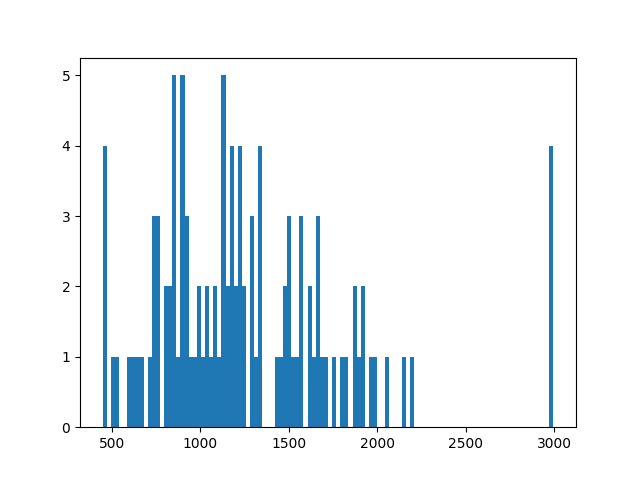

In [240]:
plt.figure()
plt.hist(makespan_all_chromosomes, bins=len(makespan_all_chromosomes))
plt.show()

# TEst

In [243]:
tasks = [x for x in range(10)]
tasks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [244]:
order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9]
order

[0, 2, 4, 6, 8, 1, 3, 5, 7, 9]

In [249]:
i = 3
task_i = tasks[order.index(i)]
task_i

6